In [1]:
import pymc3 as pm
import arviz as az
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
az.style.use('arviz-darkgrid')

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: No module named 'mkl'


KeyboardInterrupt: 

# A Simple Regression

From [Codes for Unit 1](https://www2.isye.gatech.edu/isye6420/supporting.html).

Associated lecture video: [Unit 1 Lesson 4](https://www.youtube.com/watch?v=c9VXDzJGmNw&list=PLv0FeK5oXK4l-RdT6DWJj0_upJOG2WKNO&index=4)

You don't necessarily need to set inits in PyMC. The default method of generating inits is 'jitter+adapt_diag', which chooses them based on the model and input data while adding some randomness.

If you do want to set an initial value, pass a dictionary to the start parameter of pm.sample.

```python
inits = {"alpha": np.array(0.),
         "beta": np.array(0.)}

trace = pm.sample(2000, start=inits)
```


In [ ]:
X = np.array([1, 2, 3, 4, 5])
y = np.array([1, 3, 3, 3, 5])
x_bar = np.mean(X)

In [ ]:
asr = pm.Model()

with asr:
  # priors
  alpha = pm.Normal('alpha', sigma=100)
  beta = pm.Normal('beta', sigma=100)
  # could also specify sigma directly instead, no need for precision in pymc3
  tau = pm.Gamma('tau', alpha=.001, beta=.001) 
  sigma = 1/pm.math.sqrt(tau) 

  # likelihood
  mu = alpha + beta * (X - x_bar)
  likelihood = pm.Normal('likelihood', mu=mu, sd=sigma, observed=y)

  # start sampling
  trace = pm.sample(3000, # samples
                    chains=4,
                    tune=500,
                    init='jitter+adapt_diag', 
                    random_seed=1,
                    cores=4, # parallel processing of chains
                    return_inferencedata=True)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [tau, beta, alpha]


Sampling 4 chains for 500 tune and 3_000 draw iterations (2_000 + 12_000 draws total) took 16 seconds.
The number of effective samples is smaller than 25% for some parameters.


In [ ]:
# this will remove the first 500 samples if you want burnin beyond the tuning
# from the pm.sample call
burned = trace.sel(draw=slice(500, None))

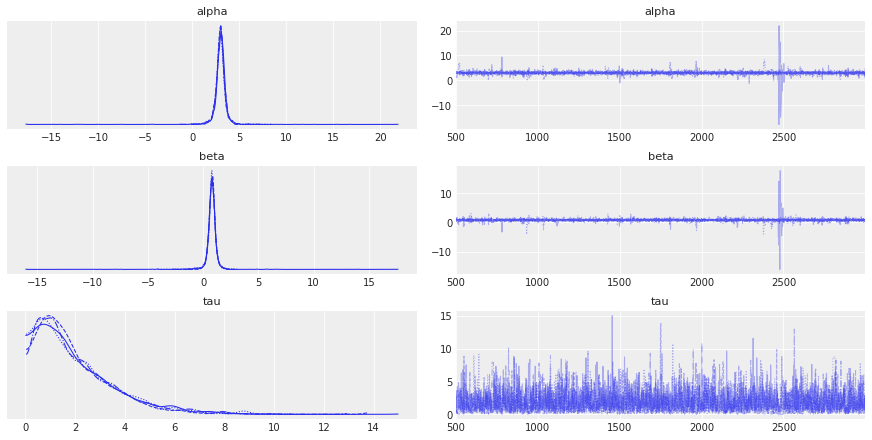

In [ ]:
az.plot_trace(burned)
plt.show()

In [ ]:
# this course (arbitrarily) asks for the 95% credible interval or set
# so specify hdi_prob = .95
az.summary(burned, hdi_prob=.95)

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,2.997,0.788,1.920,4.022,0.015,0.018,4583.0,2599.0,1.0
beta,0.787,0.568,0.062,1.489,0.008,0.012,5362.0,2388.0,1.0
tau,1.983,1.623,0.000,5.082,0.035,0.024,1845.0,1705.0,1.0


In [ ]:
# intercept
# alpha - beta * x.bar
burned.posterior.alpha.mean() - burned.posterior.beta.mean() * x_bar

<xarray.DataArray ()>
array(0.63504015)

OpenBugs results:

		      mean	  sd	    MC_error	val2.5pc	median	val97.5pc	start	sample
	alpha	 2.995	 0.5388	0.005863	1.947	   3.008	 4.015	    1000	 9001
	beta	  0.7963	0.3669	0.003795	0.08055	 0.7936	1.526	    1000	 9001
	tau	   1.88	  1.524	 0.02414	 0.1416	  1.484	 5.79	     1000	 9001


In [ ]:
# double-check with sklearn standard linear regression
reg = LinearRegression().fit(X.reshape(-1, 1), y)
reg.intercept_, reg.coef_

(0.5999999999999996, array([0.8]))